# How big is that correlation?

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd

np.random.seed(17)

## Standardized slope

In [3]:
rho = 0.36

In [4]:
from scipy.stats import norm

dist = norm(0, 1)
dist.cdf(1), dist.cdf(rho)

(0.8413447460685429, 0.6405764332179913)

Someone with g = 1 SDM is expected to have gfp = 0.36 SDM on average.

So if they're in the 84th percentile of intelligence, we expect them to be in the 64th percentile of personality.

In [5]:
def generate_correlated(xs, rho):
    mus = rho * xs
    sigma = np.sqrt(1 - rho**2)
    return np.random.normal(mus, sigma)

In [6]:
xs = np.random.normal(0, 1, size=10000)
ys = generate_correlated(xs, rho=0.36)
np.corrcoef(xs, ys)

array([[1.        , 0.35906859],
       [0.35906859, 1.        ]])

In [7]:
test_x = generate_correlated(xs, 0.8)
test_y = generate_correlated(ys, 0.8)
np.corrcoef(test_x, test_y)

array([[1.        , 0.22148199],
       [0.22148199, 1.        ]])

## gfp and g

For this example, you don't have to believe that gfp or g are real.

Some measurable cognitive capability,

and some way to quantify characteristics of personality on a scale from less to more desirable, according to the preferences of others.

In [8]:
g = xs
gfp = ys

And here's what the distribution looks like.

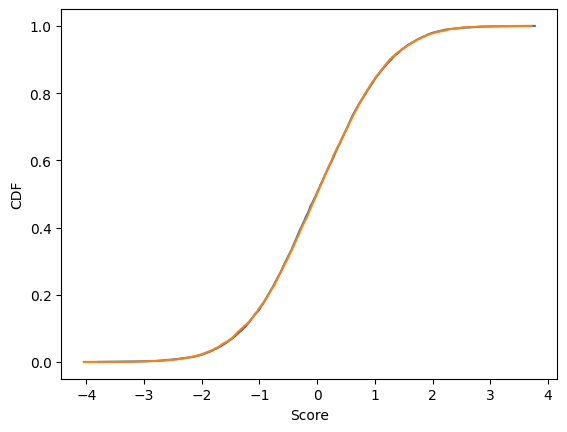

In [9]:
from empiricaldist import Cdf
import matplotlib.pyplot as plt

Cdf.from_seq(g).plot()
Cdf.from_seq(gfp).plot()

plt.xlabel('Score')
plt.ylabel('CDF');

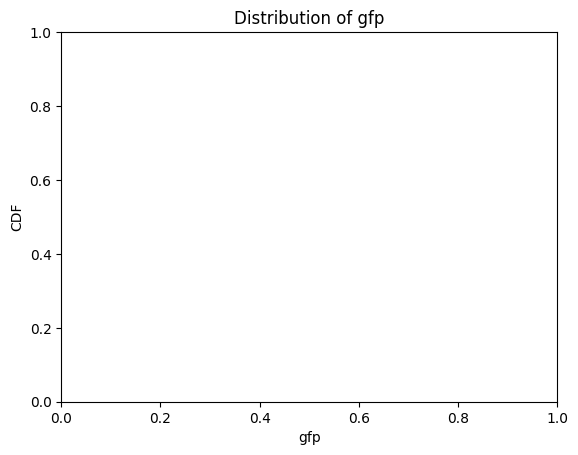

In [10]:

plt.xlabel('gfp')
plt.ylabel('CDF')
plt.title('Distribution of gfp');

The mean and standard deviation are near 0 and 1, as desired.

In [11]:
g.mean(), g.std()

(-0.006796445530111585, 1.0008011536496255)

In [12]:
gfp.mean(), gfp.std()

(-0.007494755145973502, 1.0010584830037055)

And the correlation is near $\rho$.

In [13]:
a = np.corrcoef(g, gfp)
rho_actual = a[0, 1]
rho_actual

0.35906859188655244

This scatterplot shows the relationship between gfp and SAT in my simulated dataset.

In [14]:
from matplotlib.colors import ListedColormap

def scatter(df, selector, color='C0', title=''):
    cmap = ListedColormap(['C1', color])
    subset = df.loc[:1000]
    plt.scatter(subset['g'], subset['gfp'], c=subset[selector], cmap=cmap, s=15, alpha=0.3)
    plt.xlabel('g')
    plt.ylabel('gfp')
    plt.title(title)

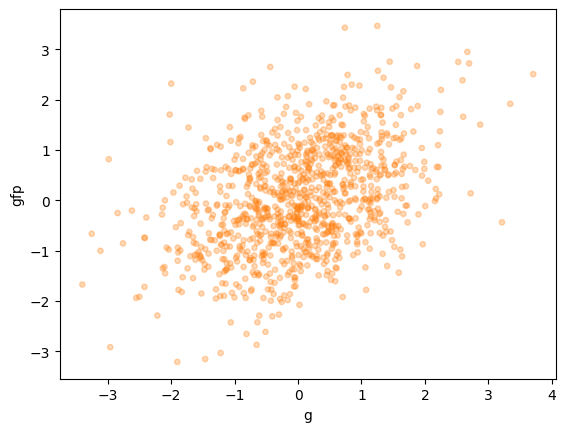

In [15]:
df = pd.DataFrame(dict(g=g, gfp=gfp, all=1))

scatter(df, 'all')

## Predictive value

Reduction in variance

In [16]:
rho ** 2

0.1296

In [17]:
import statsmodels.formula.api as smf

results = smf.ols('gfp ~ g', data=df).fit()

In [18]:
MAE_after = np.abs(results.resid).mean()
MAE_after

0.7485517889663356

In [19]:
deviation = gfp - gfp.mean()
MAE_before = np.abs(deviation).mean()
MAE_before

0.8001193291587837

In [20]:
improvement = 1 - MAE_after / MAE_before
improvement

0.06444981181327591

So we can say that knowing $g$ decreases the MAE by 7%.

That is certainly an improvement, but notice that it sounds less impressive than $R^2 = 0.13$ and much less impressive than $r = 0.36$.

## Classification accuracy

In [21]:
df['smart'] = df['g'] > 0
df['nice'] = df['gfp'] > 0
p = df.query('smart')['nice'].mean()
RR = p / 0.5
K = p / (1-p)
p, RR, K

(0.615819209039548, 1.231638418079096, 1.602941176470588)

In [22]:
df['smart'] = df['g'] > 1
df['nice'] = df['gfp'] > 0
p = df.query('smart')['nice'].mean()
RR = p / 0.5
K = p / (1-p)
p, RR, K

(0.7040557667934094, 1.4081115335868188, 2.3790149892933625)

According to https://www.statlect.com/fundamentals-of-statistics/Jeffreys-scale

This value of K is "barely worth mentioning" or "anecdotal"

## Prevalence of having it all

In [23]:
import pandas as pd

thresh = 1
both = (g > thresh) & (gfp > thresh)
combo = (g + gfp) > 2
anti = ((g > 1) & (gfp < -1)) | ((g < -1) & (gfp > 1))
df = pd.DataFrame(dict(g=g, gfp=gfp, both=both, combo=combo, anti=anti))
both.mean(), combo.mean()

(0.0486, 0.1088)

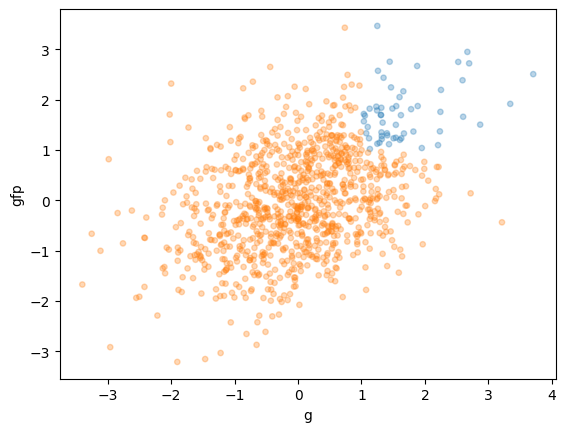

In [24]:
scatter(df, 'both', 'C0')

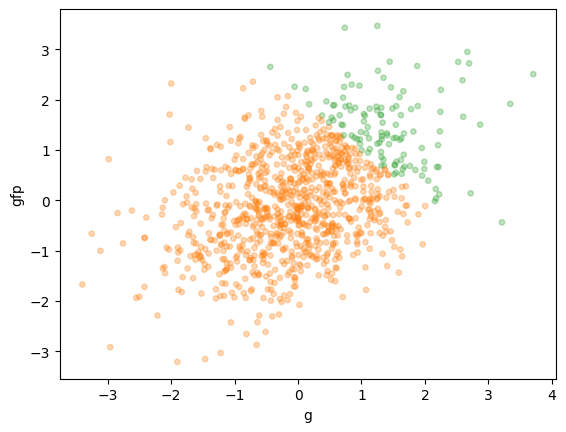

In [25]:
scatter(df, 'combo', 'C2')

If there were no correlation, how many people would be 1 standard deviation above the mean on both?

In [26]:
from scipy.stats import norm

one = norm(0, 1).sf(thresh)
both = one**2
one, both

(0.15865525393145707, 0.025171489600055125)

In [27]:
combo = norm(0, np.sqrt(2)).sf(2)
combo

0.07864960352514258

In [28]:
# double-checking the analytic result with simulation
x = np.random.normal(0, 1, size=10000)
y = np.random.normal(0, 1, size=10000)
both = (x>1) & (y>1)
combo = (x + y) > 2
both.mean(), combo.mean()

(0.0246, 0.0802)

In [29]:
df['both'].mean(), df['combo'].mean()

(0.0486, 0.1088)

## Selection

A weak correlation can be wiped out by a weak selection process, and reversed by a strong one.

In [30]:
# generate a bigger dataset so we can simulate strong selection

g = np.random.normal(0, 1, size=100000)
gfp = generate_correlated(g, rho)
df_big = pd.DataFrame(dict(g=g, gfp=gfp))

In [31]:
res = []

for thresh in np.linspace(-4, 3):
    selected = (g + gfp) > thresh
    frac = selected.mean()
    corr = df_big.loc[selected, ['g', 'gfp']].corr()
    res.append((thresh, frac, corr.iloc[0, 1]))

ts, fs, cs = np.transpose(res)

In [32]:
from scipy.interpolate import interp1d

f_example = np.array([0.7, 0.4, 0.1])
c_example = interp1d(fs, cs)(f_example)
c_example

array([ 0.02977486, -0.19729721, -0.47793225])

Text(0, 0.5, 'Correlation')

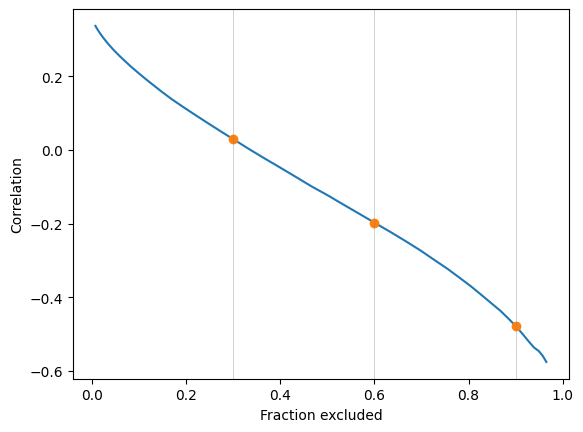

In [33]:
plt.plot(1-fs, cs)
plt.plot(1-f_example, c_example, 'o')

for f in f_example:
    plt.axvline(1-f, color='gray', lw=0.5, alpha=0.5)
plt.xlabel('Fraction excluded')
plt.ylabel('Correlation')

Text(0, 0.5, 'Fraction exceeding threshold')

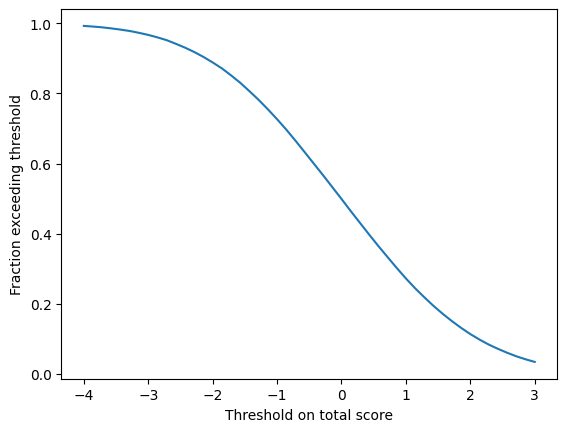

In [34]:
plt.plot(ts, fs)
plt.xlabel('Threshold on total score')
plt.ylabel('Fraction exceeding threshold')

Text(0, 0.5, 'Correlation of scores')

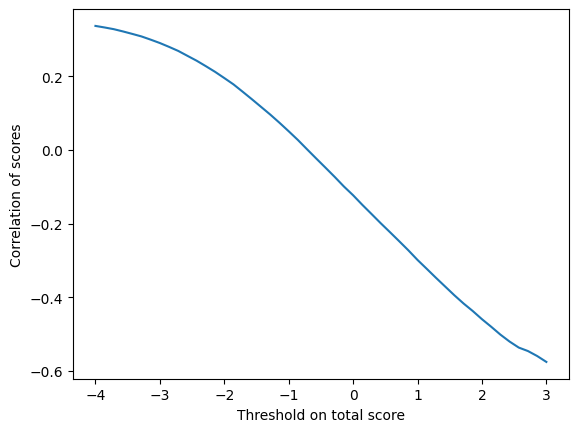

In [35]:
plt.plot(ts, cs)
plt.xlabel('Threshold on total score')
plt.ylabel('Correlation of scores')

The correlation is 0 when the we admit about 66%

In [36]:
from scipy.interpolate import interp1d

interp1d(cs, fs)(0)

array(0.6628058)

At 40% selected, correlation is -0.2

In [37]:
interp1d(fs, cs)(0.4)

array(-0.19729721)

At 10% selected, correlation is -0.48

In [38]:
interp1d(fs, cs)(0.1)

array(-0.47793225)

## Missing variable bias

In [39]:
outcome = xs + ys + np.random.normal(0, 2, size=len(xs))

In [40]:
df = pd.DataFrame(dict(xs=xs, ys=ys, outcome=outcome))

In [41]:
import statsmodels.formula.api as smf

results = smf.ols('outcome ~ xs + ys', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     3461.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:48:09   Log-Likelihood:                -21017.
No. Observations:               10000   AIC:                         4.204e+04
Df Residuals:                    9997   BIC:                         4.206e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0032      0.020     -0.162      0.871      -0.042       0.036
xs             0.9780      0.021     46.149      0.000       0.936       1.020
ys             1.0178      0.021     48.036      0.000       0.976       1.059
==============================================================================
Omnibus:                        4.727   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                4.724
Skew:                          -0.044   Prob(JB):                       0.0942
Kurtosis:                       2.941   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
results = smf.ols('outcome ~ xs', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     3749.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:48:09   Log-Likelihood:                -22055.
No. Observations:               10000   AIC:                         4.411e+04
Df Residuals:                    9998   BIC:                         4.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0084      0.022     -0.381      0.703      -0.051       0.035
xs             1.3436      0.022     61.231      0.000       1.301       1.387
==============================================================================
Omnibus:                        5.287   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.302
Skew:                          -0.050   Prob(JB):                       0.0706
Kurtosis:                       2.948   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""